# Video Segmentation Benchmark — Full Analysis Notebook
Automatically loads your CSV, computes metrics, summaries, rankings, and plots.

In [ ]:
# ## Load your full CSV automatically
import io, os, json, glob, math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use local directory for outputs
OUT_DIR = Path("./test_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Direct path to your CSV file
CSV_PATH = "SA-V/bench/sav_benchmark_summary.csv"


def load_csv_any(path_or_none):
    if path_or_none is None or not os.path.exists(str(path_or_none)):
        raise FileNotFoundError(f"CSV file not found: {path_or_none}")
    else:
        df0 = pd.read_csv(str(path_or_none))
        src = str(path_or_none)
    return df0, src

df_raw, source_csv = load_csv_any(CSV_PATH)
print(f"Loaded data source: {source_csv}")

# Convert numeric
num_cols = ["imgsz","frames","fps","latency_ms","gpu_peak_alloc_MiB","gpu_peak_reserved_MiB","cpu_peak_rss_MiB","J","JandF_proxy"]
for c in num_cols:
    if c in df_raw.columns:
        df_raw[c] = pd.to_numeric(df_raw[c], errors="coerce")

df = df_raw.copy()
if "latency_ms" in df.columns:
    df["throughput_fps_from_latency"] = 1000.0 / df["latency_ms"]
    df["speedup_vs_slowest"] = df["latency_ms"].max() / df["latency_ms"]
else:
    df["throughput_fps_from_latency"] = np.nan
    df["speedup_vs_slowest"] = np.nan

df["quality"] = (df["JandF_proxy"] if "JandF_proxy" in df.columns else pd.Series(dtype=float)).fillna(df["J"] if "J" in df.columns else np.nan)

clean_csv_path = OUT_DIR / "sa_v_bench_clean_full.csv"
df.to_csv(clean_csv_path, index=False)
print("Full CSV — Raw & Derived Metrics")
print(df.to_string())

Loaded data source: SA-V/bench/sav_benchmark_summary.csv
Full CSV — Raw & Derived Metrics
           video  object              model  imgsz  frames    fps  latency_ms  gpu_peak_alloc_MiB  gpu_peak_reserved_MiB  cpu_peak_rss_MiB       J  JandF_proxy                                               overlay  throughput_fps_from_latency  speedup_vs_slowest  quality
0     sav_000262       0   sam2_tiny_points   1024     529  12.04        83.1              4891.5                 5772.0            4767.6  0.0705       0.0705   SA-V/bench/sav_000262__obj000__sam2_tiny_points.mp4                    12.033694            3.474128   0.0705
1     sav_000262       0  sam2_small_points   1024     529  11.73        85.2              4919.3                 5772.0            6437.2  0.0398       0.0398  SA-V/bench/sav_000262__obj000__sam2_small_points.mp4                    11.737089            3.388498   0.0398
2     sav_000262       0   sam2_base_points   1024     529   9.19       108.8              505

In [19]:
# ## Per-model summary
if "model" in df.columns:
    summary = (
        df.groupby("model")
          .agg(
              videos=("video","nunique") if "video" in df.columns else ("quality","count"),
              objects=("object","nunique") if "object" in df.columns else ("quality","count"),
              mean_fps_reported=("fps","mean") if "fps" in df.columns else ("quality","mean"),
              mean_fps_from_latency=("throughput_fps_from_latency","mean"),
              mean_latency_ms=("latency_ms","mean") if "latency_ms" in df.columns else ("quality","mean"),
              mean_quality=("quality","mean"),
              mean_gpu_alloc_MiB=("gpu_peak_alloc_MiB","mean") if "gpu_peak_alloc_MiB" in df.columns else ("quality","mean"),
              mean_gpu_reserved_MiB=("gpu_peak_reserved_MiB","mean") if "gpu_peak_reserved_MiB" in df.columns else ("quality","mean"),
              mean_cpu_rss_MiB=("cpu_peak_rss_MiB","mean") if "cpu_peak_rss_MiB" in df.columns else ("quality","mean"),
              count=("quality","count"),
          )
          .reset_index()
    )
    summary["efficiency_score"] = summary["mean_quality"].fillna(0) * summary["mean_fps_from_latency"].fillna(0)
else:
    summary = pd.DataFrame()

summary_path = OUT_DIR / "per_model_summary_full.csv"
summary.to_csv(summary_path, index=False)
print("Per-Model Summary (Full CSV)")
print(summary.to_string())

Per-Model Summary (Full CSV)
               model  videos  objects  mean_fps_reported  mean_fps_from_latency  mean_latency_ms  mean_quality  mean_gpu_alloc_MiB  mean_gpu_reserved_MiB  mean_cpu_rss_MiB  count  efficiency_score
0     edgetam_points     155        9          24.696451              24.697051        41.201024      0.594998         5923.412287            6570.723549       9592.495222    293         14.694686
1   sam2_base_points     155        9           9.019078               9.018530       111.280887      0.567343         4358.407167            5566.006826       8434.308532    293          5.116603
2  sam2_large_points     155        9           5.566928               5.566759       179.960068      0.565313         4925.166553            5947.645051       8436.320137    293          3.146961
3  sam2_small_points     155        9          11.631672              11.631678        86.218430      0.547035         4221.353242            5256.737201       8594.342321    293     

In [20]:
# ## Per-object rankings
if all(c in df.columns for c in ["video","object","quality","latency_ms"]):
    rank_tables = []
    for (vid, obj), g in df.groupby(["video","object"]):
        g = g.copy()
        g["rank_quality"] = g["quality"].rank(ascending=False, method="min")
        g["rank_latency"] = g["latency_ms"].rank(ascending=True, method="min")
        g["pareto_like"] = g["rank_quality"] + g["rank_latency"]
        g = g.sort_values(["rank_quality","rank_latency","latency_ms"])
        rank_tables.append(g)
    rank_df = pd.concat(rank_tables, ignore_index=True)
else:
    rank_df = df.copy()

rank_path = OUT_DIR / "per_object_ranks_full.csv"
rank_df.to_csv(rank_path, index=False)
print("Per-Object Ranks (Full CSV)")
print(rank_df.to_string())

Per-Object Ranks (Full CSV)
           video  object              model  imgsz  frames    fps  latency_ms  gpu_peak_alloc_MiB  gpu_peak_reserved_MiB  cpu_peak_rss_MiB       J  JandF_proxy                                               overlay  throughput_fps_from_latency  speedup_vs_slowest  quality  rank_quality  rank_latency  pareto_like
0     sav_000262       0     edgetam_points   1024     529  24.60        40.6              7085.9                 7236.0            8274.9  0.2656       0.2656                                                   NaN                    24.630542            7.110837   0.2656           1.0           1.0          2.0
1     sav_000262       0   sam2_tiny_points   1024     529  12.04        83.1              4891.5                 5772.0            4767.6  0.0705       0.0705   SA-V/bench/sav_000262__obj000__sam2_tiny_points.mp4                    12.033694            3.474128   0.0705           2.0           2.0          4.0
2     sav_000262       0   sam2_b

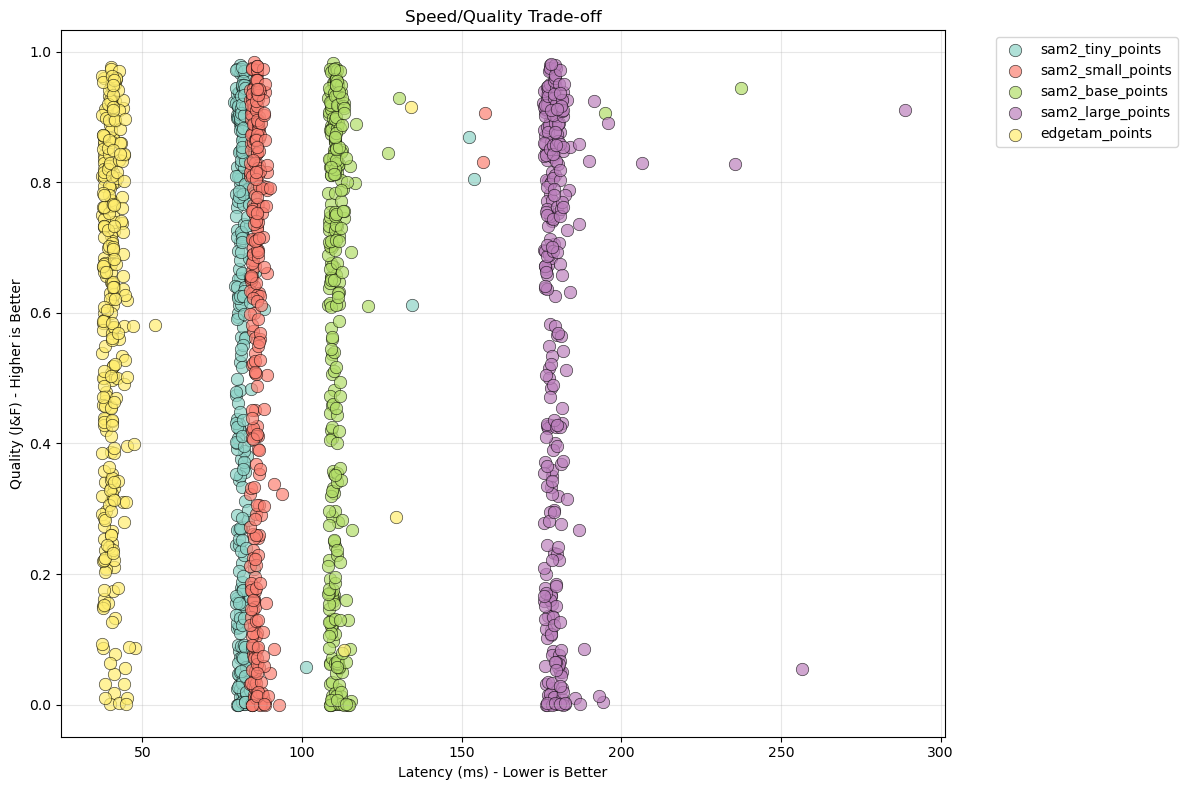

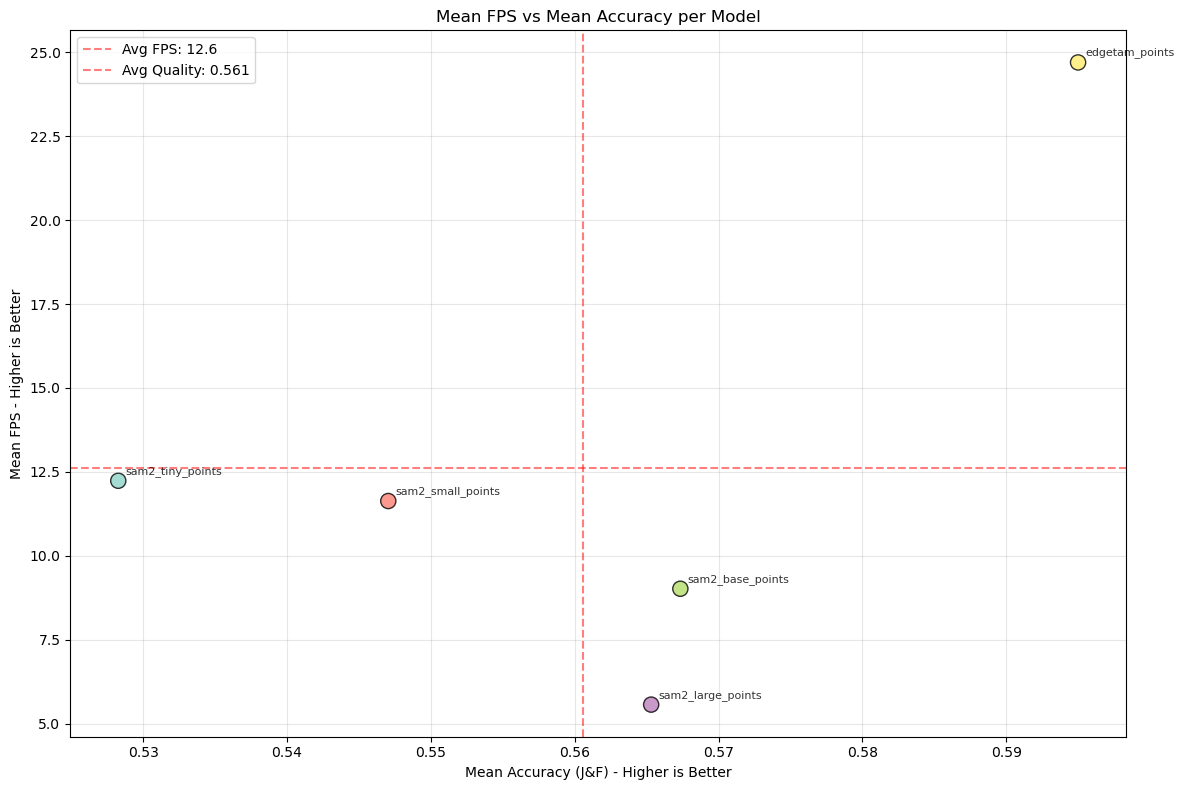

<Figure size 1200x800 with 0 Axes>

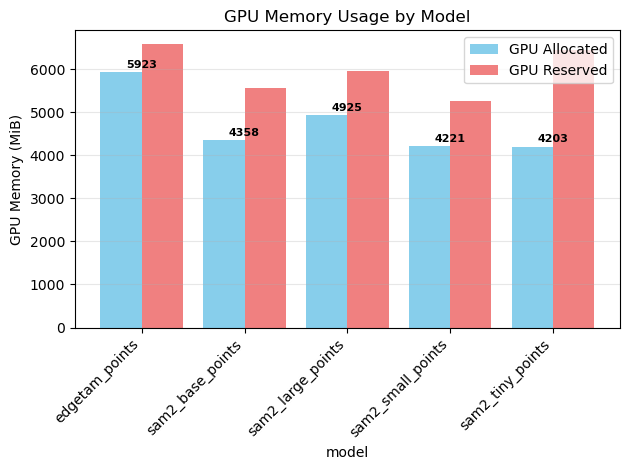

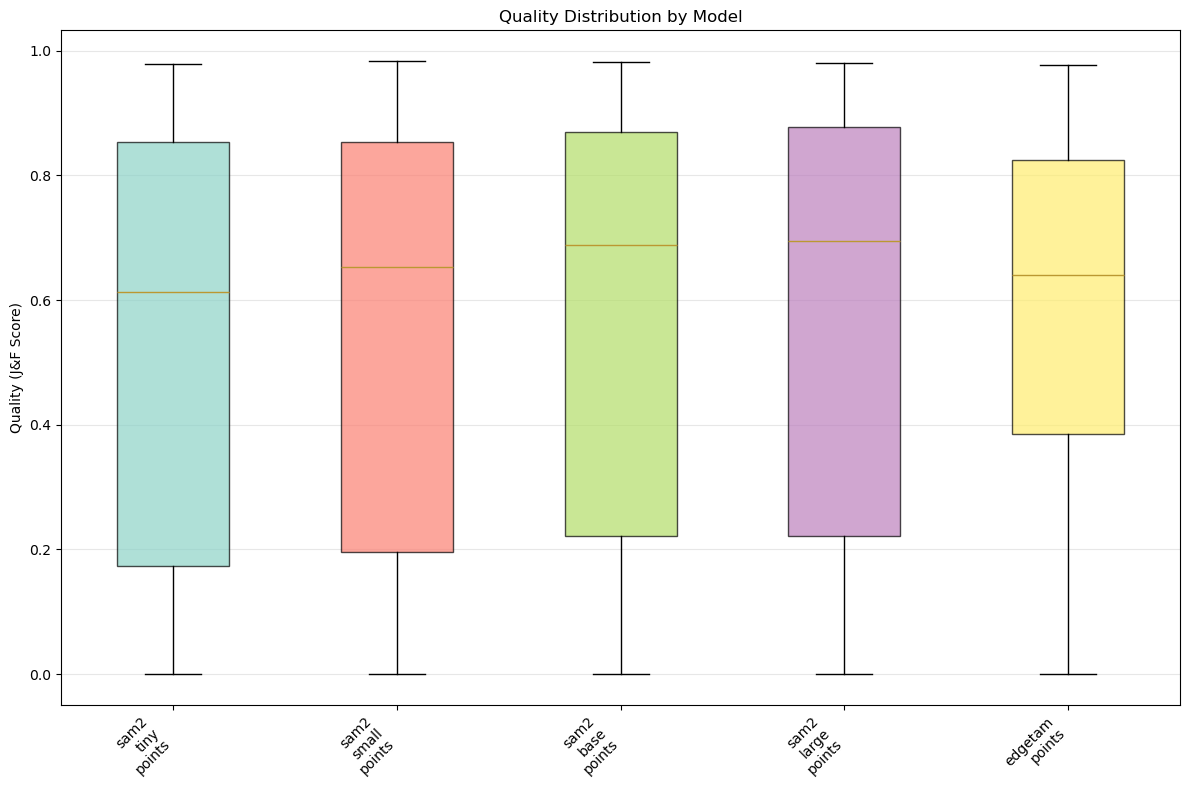

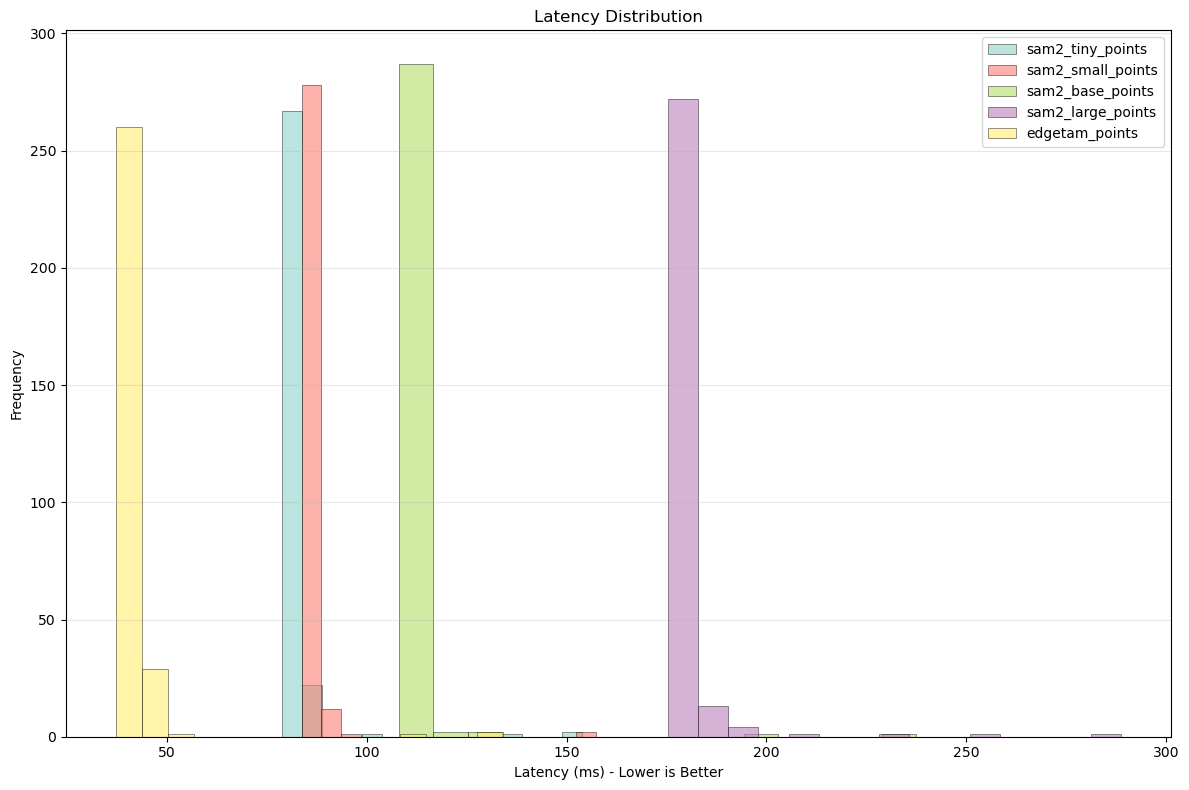

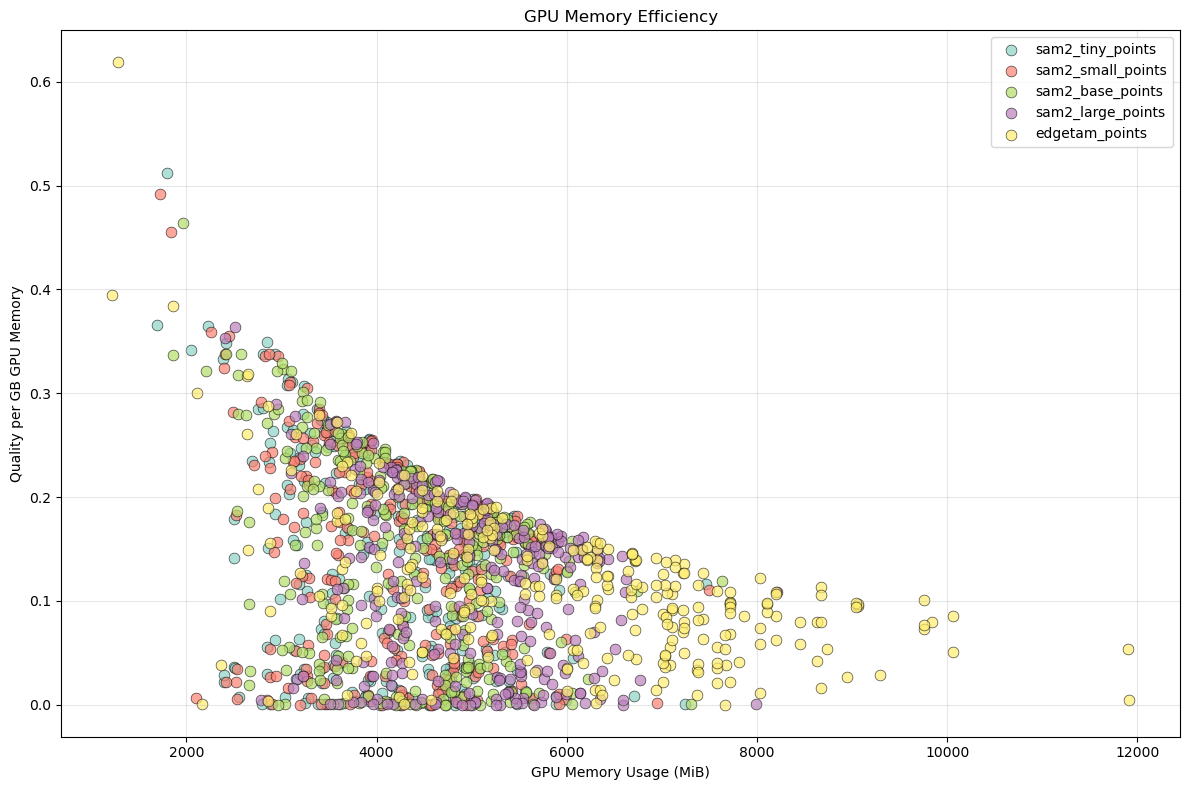

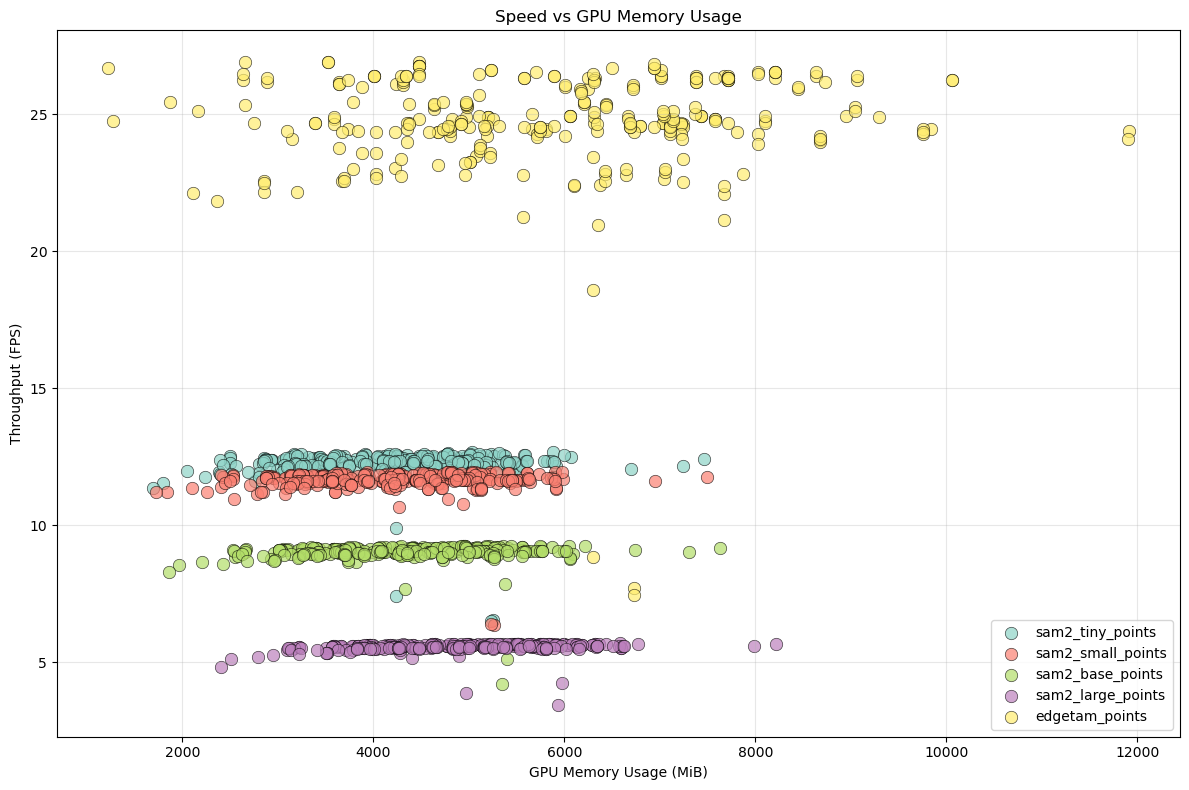

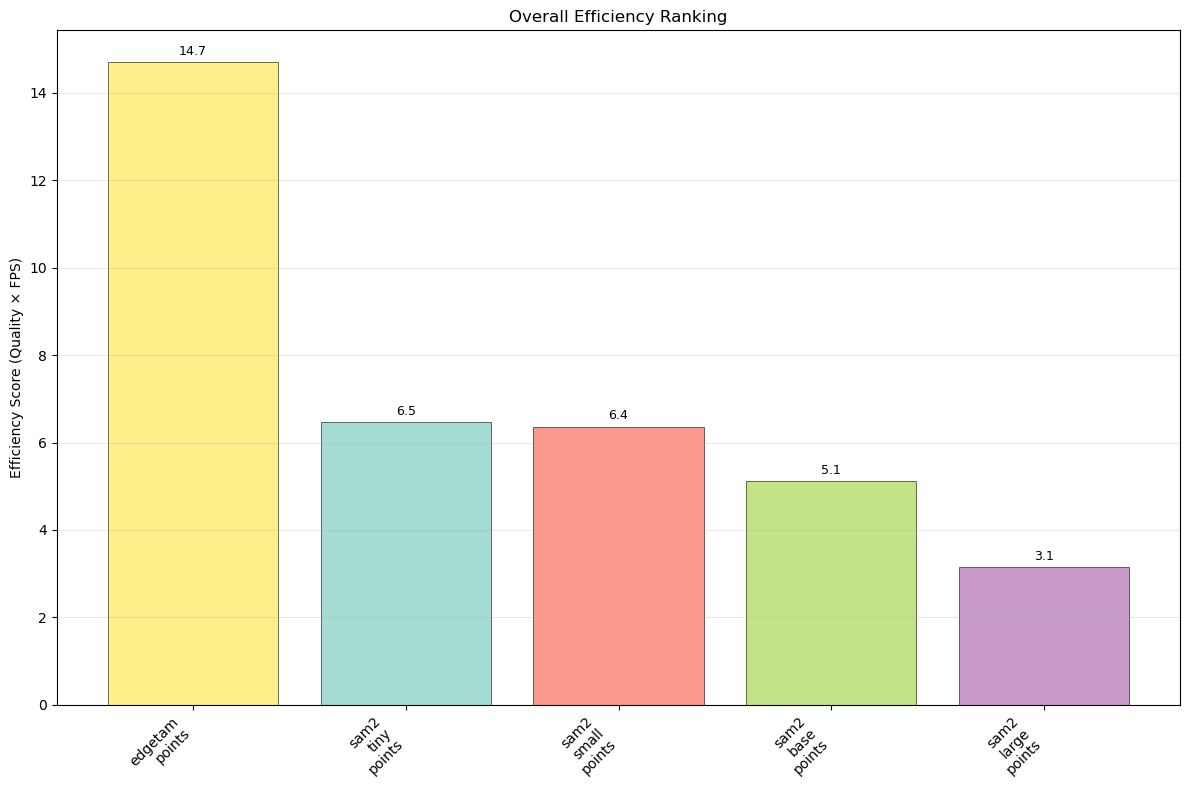

AttributeError: Figure.set() got an unexpected keyword argument 'subplot_kw'

In [21]:
# ## Comprehensive Analysis Plots - CORRECTED VERSION
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Get model colors for consistency
if "model" in df.columns:
    models = df['model'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
    model_colors = dict(zip(models, colors))
else:
    models = []
    model_colors = {}

# 1. Speed/Quality Trade-off (CORRECTED - Lower latency = better)
plt.figure(figsize=(12, 8))
if "latency_ms" in df.columns and "quality" in df.columns and "model" in df.columns:
    for model in models:
        model_data = df[df['model'] == model]
        if not model_data.empty:
            plt.scatter(model_data["latency_ms"], model_data["quality"], 
                       label=model, alpha=0.7, s=80, color=model_colors[model], 
                       edgecolors='black', linewidth=0.5)
    
    plt.xlabel("Latency (ms) - Lower is Better")
    plt.ylabel("Quality (J&F) - Higher is Better") 
    plt.title("Speed/Quality Trade-off")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_DIR / "01_speed_quality_tradeoff.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. REQUESTED: Mean FPS vs Mean Accuracy per Model 
plt.figure(figsize=(12, 8))
if not summary.empty and "mean_fps_from_latency" in summary.columns and "mean_quality" in summary.columns:
    plt.scatter(summary["mean_quality"], summary["mean_fps_from_latency"], 
               s=120, alpha=0.8, edgecolors='black', linewidth=1,
               c=[model_colors[model] for model in summary['model']])
    
    # Add model labels
    for _, row in summary.iterrows():
        plt.annotate(row['model'], 
                    (row['mean_quality'], row['mean_fps_from_latency']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)
    
    plt.xlabel("Mean Accuracy (J&F) - Higher is Better")
    plt.ylabel("Mean FPS - Higher is Better") 
    plt.title("Mean FPS vs Mean Accuracy per Model")
    plt.grid(True, alpha=0.3)
    
    # Add quadrant reference lines
    mean_quality = summary["mean_quality"].mean()
    mean_fps = summary["mean_fps_from_latency"].mean()
    plt.axhline(y=mean_fps, color='red', linestyle='--', alpha=0.5, label=f'Avg FPS: {mean_fps:.1f}')
    plt.axvline(x=mean_quality, color='red', linestyle='--', alpha=0.5, label=f'Avg Quality: {mean_quality:.3f}')
    plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(OUT_DIR / "02_mean_fps_vs_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. GPU Memory Usage Comparison (CORRECTED - Focus on GPU memory)
plt.figure(figsize=(12, 8))
if "gpu_peak_alloc_MiB" in df.columns and "model" in df.columns:
    # Focus primarily on GPU allocated memory (most important metric)
    gpu_cols = ['gpu_peak_alloc_MiB']
    if 'gpu_peak_reserved_MiB' in df.columns:
        gpu_cols.append('gpu_peak_reserved_MiB')
    
    df_mem = df.groupby('model')[gpu_cols].mean()
    ax = df_mem.plot(kind='bar', width=0.8, 
                     color=['skyblue', 'lightcoral'][:len(gpu_cols)])
    plt.title("GPU Memory Usage by Model")
    plt.ylabel("GPU Memory (MiB)")
    plt.xticks(rotation=45, ha='right')
    plt.legend(['GPU Allocated', 'GPU Reserved'][:len(gpu_cols)], fontsize=10)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars for GPU allocated memory
    for i, (model, values) in enumerate(df_mem.iterrows()):
        plt.text(i, values['gpu_peak_alloc_MiB'] + 50, f'{values["gpu_peak_alloc_MiB"]:.0f}', 
                ha='center', va='bottom', fontsize=8, weight='bold')
plt.tight_layout()
plt.savefig(OUT_DIR / "03_gpu_memory_usage.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. Quality Distribution by Model (IMPROVED Box Plot)
plt.figure(figsize=(12, 8))
if "model" in df.columns and "quality" in df.columns:
    quality_data = []
    labels = []
    for model in models:
        model_quality = df[df['model'] == model]['quality'].dropna()
        if len(model_quality) > 0:
            quality_data.append(model_quality.values)
            labels.append(model.replace('_', '\n'))
    
    if quality_data:
        bp = plt.boxplot(quality_data, labels=labels, patch_artist=True)
        # Color the boxes according to model colors
        for patch, model in zip(bp['boxes'], models[:len(bp['boxes'])]):
            if model in model_colors:
                patch.set_facecolor(model_colors[model])
                patch.set_alpha(0.7)
        plt.title("Quality Distribution by Model")
        plt.ylabel("Quality (J&F Score)")
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(OUT_DIR / "04_quality_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# 5. Latency Distribution (IMPROVED)
plt.figure(figsize=(12, 8))
if "latency_ms" in df.columns and "model" in df.columns:
    for model in models:
        model_data = df[df['model'] == model]['latency_ms'].dropna()
        if len(model_data) > 0:
            plt.hist(model_data, alpha=0.6, label=model, bins=15, 
                    color=model_colors[model], edgecolor='black', linewidth=0.5)
    plt.xlabel("Latency (ms) - Lower is Better")
    plt.ylabel("Frequency")
    plt.title("Latency Distribution")
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(OUT_DIR / "05_latency_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# 6. GPU Memory Efficiency (CORRECTED - Quality per GPU Memory)
plt.figure(figsize=(12, 8))
if all(col in df.columns for col in ["quality", "gpu_peak_alloc_MiB", "model"]):
    # Calculate efficiency as quality per GB of GPU memory
    df_temp = df.copy()
    df_temp['quality_per_gb'] = df_temp['quality'] / (df_temp['gpu_peak_alloc_MiB'] / 1024)  # per GB
    
    for model in models:
        model_data = df_temp[df_temp['model'] == model]
        if not model_data.empty:
            plt.scatter(model_data["gpu_peak_alloc_MiB"], model_data["quality_per_gb"], 
                       label=model, alpha=0.7, s=60, color=model_colors[model],
                       edgecolors='black', linewidth=0.5)
    plt.xlabel("GPU Memory Usage (MiB)")
    plt.ylabel("Quality per GB GPU Memory")
    plt.title("GPU Memory Efficiency")
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_DIR / "06_gpu_memory_efficiency.png", dpi=300, bbox_inches='tight')
plt.show()

# 7. Speed vs GPU Memory Trade-off (CORRECTED)
plt.figure(figsize=(12, 8))
if all(col in df.columns for col in ["throughput_fps_from_latency", "gpu_peak_alloc_MiB", "model"]):
    for model in models:
        model_data = df[df['model'] == model]
        if not model_data.empty:
            plt.scatter(model_data["gpu_peak_alloc_MiB"], model_data["throughput_fps_from_latency"], 
                       label=model, alpha=0.7, s=80, color=model_colors[model],
                       edgecolors='black', linewidth=0.5)
    plt.xlabel("GPU Memory Usage (MiB)")
    plt.ylabel("Throughput (FPS)")
    plt.title("Speed vs GPU Memory Usage")
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_DIR / "07_speed_vs_memory.png", dpi=300, bbox_inches='tight')
plt.show()

# 8. Model Efficiency Score Ranking (IMPROVED)
plt.figure(figsize=(12, 8))
if not summary.empty and "efficiency_score" in summary.columns:
    # Sort by efficiency score for better visualization
    summary_sorted = summary.sort_values('efficiency_score', ascending=False)
    bars = plt.bar(range(len(summary_sorted)), summary_sorted["efficiency_score"], 
                  color=[model_colors[model] for model in summary_sorted['model']],
                  alpha=0.8, edgecolor='black', linewidth=0.5)
    
    plt.xticks(range(len(summary_sorted)), 
              [m.replace('_', '\n') for m in summary_sorted['model']], 
              rotation=45, ha='right')
    plt.ylabel("Efficiency Score (Quality × FPS)")
    plt.title("Overall Efficiency Ranking")
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, summary_sorted["efficiency_score"])):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{score:.1f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig(OUT_DIR / "08_efficiency_ranking.png", dpi=300, bbox_inches='tight')
plt.show()

# 9. Performance Radar Chart (ENHANCED)
plt.figure(figsize=(10, 10), subplot_kw=dict(projection='polar'))
if not summary.empty and len(summary) > 0:
    # Select meaningful metrics for radar chart
    radar_metrics = []
    metric_labels = []
    
    # Check which metrics are available and meaningful
    if 'mean_quality' in summary.columns:
        radar_metrics.append('mean_quality')
        metric_labels.append('Quality')
    if 'mean_fps_from_latency' in summary.columns:
        radar_metrics.append('mean_fps_from_latency')
        metric_labels.append('Speed (FPS)')
    if 'efficiency_score' in summary.columns:
        radar_metrics.append('efficiency_score')
        metric_labels.append('Efficiency')
    if 'mean_gpu_alloc_MiB' in summary.columns:
        # Invert GPU memory (lower is better) for radar chart
        summary_radar = summary.copy()
        max_mem = summary['mean_gpu_alloc_MiB'].max()
        summary_radar['gpu_efficiency'] = (max_mem - summary_radar['mean_gpu_alloc_MiB']) / max_mem
        radar_metrics.append('gpu_efficiency')
        metric_labels.append('Memory Eff.')
    
    if len(radar_metrics) >= 3:
        angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        
        # Show top 4 models by efficiency
        top_models = summary.nlargest(min(4, len(summary)), 'efficiency_score')
        
        for _, model_row in top_models.iterrows():
            model = model_row['model']
            values = []
            for metric in radar_metrics:
                if metric == 'gpu_efficiency':
                    val = summary_radar[summary_radar['model'] == model]['gpu_efficiency'].iloc[0]
                    series = summary_radar[metric]
                else:
                    val = model_row[metric]
                    series = summary[metric]
                
                # Normalize to 0-1 scale
                max_val = series.max()
                min_val = series.min()
                if max_val > min_val:
                    normalized = (val - min_val) / (max_val - min_val)
                else:
                    normalized = 0.5
                values.append(normalized)
            
            values += values[:1]  # Complete the circle
            
            color = model_colors.get(model, 'gray')
            plt.plot(angles, values, 'o-', linewidth=2, label=model, 
                    alpha=0.8, color=color, markersize=4)
            plt.fill(angles, values, alpha=0.1, color=color)
        
        plt.xticks(angles[:-1], metric_labels)
        plt.title("Multi-Metric Performance (Top 4 Models)", pad=20)
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)
        plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(OUT_DIR / "09_performance_radar.png", dpi=300, bbox_inches='tight')
plt.show()

# 10. GPU Memory vs Quality Trade-off (NEW)
plt.figure(figsize=(12, 8))
if all(col in df.columns for col in ["quality", "gpu_peak_alloc_MiB", "model"]):
    for model in models:
        model_data = df[df['model'] == model]
        if not model_data.empty:
            plt.scatter(model_data["gpu_peak_alloc_MiB"], model_data["quality"], 
                       label=model, alpha=0.7, s=80, color=model_colors[model],
                       edgecolors='black', linewidth=0.5)
    
    plt.xlabel("GPU Memory Usage (MiB)")
    plt.ylabel("Quality (J&F)")
    plt.title("GPU Memory vs Quality")
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_DIR / "10_memory_vs_quality.png", dpi=300, bbox_inches='tight')
plt.show()

# 11. Model Size Comparison (NEW - if we can extract size info)
plt.figure(figsize=(12, 8))
if "model" in df.columns:
    # Extract model sizes from names
    df_temp = df.copy()
    size_mapping = {'tiny': 1, 'small': 2, 'base': 3, 'large': 4, 'edgetam': 2.5}
    df_temp['model_size_num'] = df_temp['model'].apply(
        lambda x: next((size_mapping[size] for size in size_mapping if size in x.lower()), 2.5))
    
    if 'quality' in df.columns:
        for model in models:
            model_data = df_temp[df_temp['model'] == model]
            if not model_data.empty:
                size_val = model_data['model_size_num'].iloc[0]
                quality_vals = model_data['quality']
                plt.scatter([size_val] * len(quality_vals), quality_vals, 
                           label=model, alpha=0.7, s=80, color=model_colors[model],
                           edgecolors='black', linewidth=0.5)
        
        plt.xlabel("Model Size Category")
        plt.ylabel("Quality (J&F)")
        plt.title("Model Size vs Quality")
        plt.xticks([1, 2, 2.5, 3, 4], ['Tiny', 'Small', 'EdgeTAM', 'Base', 'Large'])
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_DIR / "11_model_size_vs_quality.png", dpi=300, bbox_inches='tight')
plt.show()

# 12. Throughput Distribution (NEW)
plt.figure(figsize=(12, 8))
if "throughput_fps_from_latency" in df.columns and "model" in df.columns:
    throughput_data = []
    labels = []
    for model in models:
        model_throughput = df[df['model'] == model]['throughput_fps_from_latency'].dropna()
        if len(model_throughput) > 0:
            throughput_data.append(model_throughput.values)
            labels.append(model.replace('_', '\n'))
    
    if throughput_data:
        bp = plt.boxplot(throughput_data, labels=labels, patch_artist=True)
        # Color the boxes according to model colors
        for patch, model in zip(bp['boxes'], models[:len(bp['boxes'])]):
            if model in model_colors:
                patch.set_facecolor(model_colors[model])
                patch.set_alpha(0.7)
        plt.title("Throughput Distribution by Model")
        plt.ylabel("Throughput (FPS)")
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(OUT_DIR / "12_throughput_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# ENHANCED SUMMARY STATISTICS WITH CORRECTED METRICS
print("\n" + "="*60)
print("DETAILED PERFORMANCE ANALYSIS - CORRECTED METRICS")
print("="*60)

if not summary.empty:
    print(f"\n{'='*20} METRIC DEFINITIONS {'='*20}")
    print("J&F Score: Jaccard & F-measure (0-1, higher = better segmentation quality)")
    print("FPS: Frames per second (higher = faster processing)")
    print("Latency: Milliseconds per frame (lower = faster)")
    print("Efficiency: Quality × FPS (higher = better overall performance)")
    print("GPU Memory: Peak GPU allocated memory in MiB (lower = more efficient)")
    print("CPU Memory: Peak CPU RSS memory in MiB (for reference)")
    
    print(f"\n{'='*20} TOP PERFORMERS {'='*20}")
    
    print("\nTOP 3 MODELS BY QUALITY (J&F Score):")
    if 'mean_gpu_alloc_MiB' in summary.columns:
        top_quality = summary.nlargest(3, 'mean_quality')[['model', 'mean_quality', 'mean_latency_ms', 'mean_gpu_alloc_MiB']]
        for i, (_, row) in enumerate(top_quality.iterrows(), 1):
            print(f"  {i}. {row['model']}: {row['mean_quality']:.4f} quality @ {row['mean_latency_ms']:.1f}ms ({row['mean_gpu_alloc_MiB']:.0f} MiB GPU)")
    else:
        top_quality = summary.nlargest(3, 'mean_quality')[['model', 'mean_quality', 'mean_latency_ms']]
        for i, (_, row) in enumerate(top_quality.iterrows(), 1):
            print(f"  {i}. {row['model']}: {row['mean_quality']:.4f} quality @ {row['mean_latency_ms']:.1f}ms")
    
    print("\nTOP 3 MODELS BY SPEED (Lowest Latency):")
    top_speed = summary.nsmallest(3, 'mean_latency_ms')[['model', 'mean_latency_ms', 'mean_quality', 'mean_fps_from_latency']]
    for i, (_, row) in enumerate(top_speed.iterrows(), 1):
        print(f"  {i}. {row['model']}: {row['mean_latency_ms']:.1f}ms ({row['mean_fps_from_latency']:.1f} FPS) @ {row['mean_quality']:.4f} quality")
    
    print("\nTOP 3 MODELS BY OVERALL EFFICIENCY (Quality × Speed):")
    top_efficiency = summary.nlargest(3, 'efficiency_score')[['model', 'efficiency_score', 'mean_quality', 'mean_fps_from_latency']]
    for i, (_, row) in enumerate(top_efficiency.iterrows(), 1):
        eff_breakdown = f"{row['mean_quality']:.4f} × {row['mean_fps_from_latency']:.1f}"
        print(f"  {i}. {row['model']}: {row['efficiency_score']:.3f} ({eff_breakdown})")
    
    if 'mean_gpu_alloc_MiB' in summary.columns:
        print("\nTOP 3 MODELS BY GPU MEMORY EFFICIENCY (Lowest GPU Usage):")
        top_memory = summary.nsmallest(3, 'mean_gpu_alloc_MiB')[['model', 'mean_gpu_alloc_MiB', 'mean_quality']]
        for i, (_, row) in enumerate(top_memory.iterrows(), 1):
            print(f"  {i}. {row['model']}: {row['mean_gpu_alloc_MiB']:.0f} MiB GPU @ {row['mean_quality']:.4f} quality")
    
    # Quality vs Speed Analysis
    print(f"\n{'='*20} TRADE-OFF ANALYSIS {'='*20}")
    best_quality = summary.loc[summary['mean_quality'].idxmax()]
    fastest_model = summary.loc[summary['mean_latency_ms'].idxmin()]
    most_efficient = summary.loc[summary['efficiency_score'].idxmax()]
    
    print(f"\nBEST QUALITY: {best_quality['model']} ({best_quality['mean_quality']:.4f})")
    print(f"FASTEST: {fastest_model['model']} ({fastest_model['mean_latency_ms']:.1f}ms)")
    print(f"MOST EFFICIENT: {most_efficient['model']} ({most_efficient['efficiency_score']:.3f})")
    
    if 'mean_gpu_alloc_MiB' in summary.columns:
        lowest_memory = summary.loc[summary['mean_gpu_alloc_MiB'].idxmin()]
        print(f"LOWEST GPU MEMORY: {lowest_memory['model']} ({lowest_memory['mean_gpu_alloc_MiB']:.0f} MiB)")

print(f"\nDetailed analysis saved to: {OUT_DIR}")
print("Individual graphs saved as: 01_speed_quality_tradeoff.png through 12_throughput_distribution.png")
print("="*60)